# Sample solutions

In [1]:
# !pip install memory-profiler --user
# !pip install matplotlib --user
# !pip install yellowbrick --user
!pip3 install sklearn --user

In [2]:
%matplotlib inline
%load_ext memory_profiler
import numpy as np
from scipy import sparse
import pandas as pd
from sklearn.decomposition import PCA, KernelPCA
from sklearn.manifold import TSNE, MDS, Isomap
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics.pairwise import cosine_similarity
import matplotlib.pyplot as plt
import time
import pandas as pd
import pickle
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from yellowbrick.cluster import SilhouetteVisualizer
import matplotlib as mpl
from yellowbrick.style import rcmod
from scipy.stats import spearmanr
from memory_profiler import profile

In [3]:
# Yellowbrick changes the plotting settings, reset to default here
rcmod.reset_orig()

/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.avconv_path rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The animation.html_args rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The keymap.all_axes rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  self[key] = other[key]
/usr/lib/python3.8/_collections_abc.py:832: MatplotlibDeprecationWarning: 
The savefig.jpeg_quality rcparam was deprecated in Matplotlib 3.3 and will be rem

# Problem 1

1. Load the data

In [4]:
Xred=np.load("../data/highdim/p2_unsupervised_reduced/X.npy")
X = np.load("../data/highdim/p2_unsupervised/X.npy")

6. MDS (sklearn version is nonlinear)

In [5]:
kmeans = KMeans(3, tol=1e-6)
kmeans.fit(X)
labels=kmeans.labels_

In [11]:
X = X
y = labels

# Split data into train and test using k-fold cross-validation
# with independent test data set.
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.3,
                                                    shuffle=True,
                                                    random_state=42
                                                   )

In [12]:
X_train.shape

(1518, 45768)

In [13]:
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV
logistic = linear_model.LogisticRegression(solver='liblinear')
# Create regularization penalty space
penalty = ['l1', 'l2']

# Create regularization hyperparameter space
C = np.logspace(0, 4, 10)

# Create hyperparameter options
hyperparameters = dict(C=C, penalty=penalty)
clf = GridSearchCV(logistic, hyperparameters, cv=3, verbose=0,n_jobs = -1)
best_model = clf.fit(X_train, y_train)

In [16]:
# View best hyperparameters
print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Best C:', best_model.best_estimator_.get_params()['C'])

Best Penalty: l2
Best C: 1.0


In [15]:
best_model.best_estimator_.get_params()

{'C': 1.0,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'liblinear',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [23]:
clf_l2_LR = LogisticRegression(multi_class='multinomial',C=0.01, penalty='l2', tol=0.01, solver='saga')
clf_l2_LR.fit(X_train, y_train)
coef_l2_LR = clf_l2_LR.coef_.ravel()
sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100

print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
print("{:<40} {:.2f}".format("Score with L2 penalty:",
                                 clf_l2_LR.score(X_test, y_test)))

Sparsity with L2 penalty:                21.30%
Score with L2 penalty:                   1.00


In [54]:
print(y_train.value_counts(normalize=True))

# Using sklearn accuracy_score
import numpy as np
from sklearn.metrics import accuracy_score

majority_class = y_train.mode()[0]
prediction = np.full(shape=y_train.shape, 
                     fill_value=majority_class)

accuracy_score(y_train, prediction)

0    0.509642
1    0.390266
2    0.100092
dtype: float64


0.509641873278237

In [55]:
# Data pre-processing, Feature selection and Model selection.

# Imports for pipeline
from sklearn.pipeline import make_pipeline

from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression

# Create pipeline
pipeline = make_pipeline(\
                         RobustScaler(),
                         SelectKBest(f_classif),
                         LogisticRegression(solver='lbfgs'))

In [71]:
penalty = ['l1', 'l2']

# Create a list of values of the regularization parameter
C = np.logspace(-4, 4, 50)

hyperparameters = dict(C=C, penalty=penalty)

In [72]:
# Model validation.
from sklearn import linear_model, datasets
from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'selectkbest__k': [1, 2, 3, 4],
#     'logisticregression__class_weight': [None,'balancezzzzZZd'],
#     'logisticregression__C': [.0001, .001, .01, .1, 1.0, 10.0, 100.00, 1000.0, 10000.0]
# }
logistic = linear_model.LogisticRegression()
clf = GridSearchCV(logistic, hyperparameters, cv=5, verbose=0)

clf.fit(X_train, y_train)

/home/banach/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:610: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/banach/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 593, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/banach/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 1306, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/home/banach/.local/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py", line 443, in _check_solver
    raise ValueError("Solver %s supports only 'l2' or 'none' penalties, "
ValueError: Solver lbfgs supports only 'l2' or 'none' penalties, got l1 penalty.

  warnings.warn("Estimator fit failed. The score on this train-test"
/home/banach/.local/lib/python3.8/site-packages/s

/home/banach/.local/lib/python3.8/site-packages/sklearn/utils/validation.py:63: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  return f(*args, **kwargs)


KeyboardInterrupt: 

C=1.00
Sparsity with L1 penalty:                42.81%
Sparsity with Elastic-Net penalty:       31.23%
Sparsity with L2 penalty:                21.30%
Score with L1 penalty:                   0.94
Score with Elastic-Net penalty:          0.94
Score with L2 penalty:                   0.93
C=0.10
Sparsity with L1 penalty:                91.17%
Sparsity with Elastic-Net penalty:       80.13%
Sparsity with L2 penalty:                21.30%
Score with L1 penalty:                   0.96
Score with Elastic-Net penalty:          0.95
Score with L2 penalty:                   0.93
C=0.01
Sparsity with L1 penalty:                99.88%
Sparsity with Elastic-Net penalty:       99.54%
Sparsity with L2 penalty:                21.30%
Score with L1 penalty:                   1.00
Score with Elastic-Net penalty:          0.98
Score with L2 penalty:                   0.93


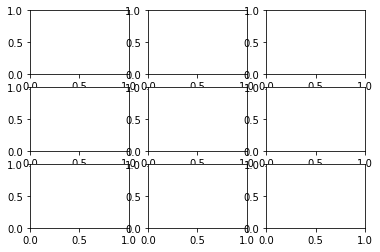

In [25]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.preprocessing import StandardScaler

# X, y = datasets.load_digits(return_X_y=True)
# scaller=StandardScaler().fit(Xr_train)
X = StandardScaler().fit_transform(X_train)
y = y_train #StandardScaler().fit_transform(yr_train.reshape(1, -1))

# scaller2= StandardScaler().fit(Xr_test)
xtest = StandardScaler().fit_transform(X_test)
ytest = y_test # StandardScaler().fit_transform(yr_test.reshape(1, -1))

l1_ratio = 0.5  # L1 weight in the Elastic-Net regularization

fig, axes = plt.subplots(3, 3)

# Set regularization parameter
for i, (C, axes_row) in enumerate(zip((1, 0.1, 0.01), axes)):
    # turn down tolerance for short training time
    clf_l1_LR = LogisticRegression(C=C, penalty='l1', tol=0.01, solver='saga')
    clf_l2_LR = LogisticRegression(C=C, penalty='l2', tol=0.01, solver='saga')
    clf_en_LR = LogisticRegression(C=C, penalty='elasticnet', solver='saga',
                                   l1_ratio=l1_ratio, tol=0.01)
    clf_l1_LR.fit(X, y)
    clf_l2_LR.fit(X, y)
    clf_en_LR.fit(X, y)

    coef_l1_LR = clf_l1_LR.coef_.ravel()
    coef_l2_LR = clf_l2_LR.coef_.ravel()
    coef_en_LR = clf_en_LR.coef_.ravel()

    # coef_l1_LR contains zeros due to the
    # L1 sparsity inducing norm

    sparsity_l1_LR = np.mean(coef_l1_LR == 0) * 100
    sparsity_l2_LR = np.mean(coef_l2_LR == 0) * 100
    sparsity_en_LR = np.mean(coef_en_LR == 0) * 100

    print("C=%.2f" % C)
    print("{:<40} {:.2f}%".format("Sparsity with L1 penalty:", sparsity_l1_LR))
    print("{:<40} {:.2f}%".format("Sparsity with Elastic-Net penalty:",
                                  sparsity_en_LR))
    print("{:<40} {:.2f}%".format("Sparsity with L2 penalty:", sparsity_l2_LR))
    print("{:<40} {:.2f}".format("Score with L1 penalty:",
                                 clf_l1_LR.score(xtest, ytest)))
    print("{:<40} {:.2f}".format("Score with Elastic-Net penalty:",
                                 clf_en_LR.score(xtest, ytest)))
    print("{:<40} {:.2f}".format("Score with L2 penalty:",
                                 clf_l2_LR.score(xtest, ytest)))

#     if i == 0:
#         axes_row[0].set_title("L1 penalty")
#         axes_row[1].set_title("Elastic-Net\nl1_ratio = %s" % l1_ratio)
#         axes_row[2].set_title("L2 penalty")

#     for ax, coefs in zip(axes_row, [coef_l1_LR, coef_en_LR, coef_l2_LR]):
#         ax.imshow(np.abs(coefs[0:5929].reshape(77, 77)), interpolation='nearest',
#                   cmap='binary', vmax=1, vmin=0)
#         ax.set_xticks(())
#         ax.set_yticks(())

#     axes_row[0].set_ylabel('C = %s' % C)

# plt.show()

In [20]:
elas_ratios=[x/10.0 for x in range(1,11,1)]
alpha_ratios=[x/10.0 for x in range(1,11,1)]

In [29]:
   for ax, coefs in zip(axes_row, [coef_l1_LR, coef_en_LR, coef_l2_LR]):
        coefs[1:5929].reshape(77, 77)

ValueError: cannot reshape array of size 5928 into shape (77,77)

In [ ]:
model_score_lst=[]
for el_ratio in elas_ratios:
    for al_ratio in alpha_ratios:
        model=SGDClassifier()

In [ ]:
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot
 
# get the dataset
def get_dataset():
#     X, y = make_classification(n_samples=1000, n_features=20, n_informative=15, n_redundant=5, random_state=1, n_classes=3)
    return Xr_train, yr_train
 
# get a list of models to evaluate
def get_models():
    models = dict()
    for p in [0.0, 0.0001, 0.001, 0.01, 0.1, 1.0]:
        # create name for model
        key = '%.4f' % p
        # turn off penalty in some cases
        if p == 0.0:
            # no penalty in this case
            models[key] = LogisticRegression(C=p, penalty='none', solver='saga', tol=0.1)
            
#             models[key] = LogisticRegression(multi_class='multinomial', solver='liblinear', penalty='none')
        else:
            models[key] = LogisticRegression(C=p, penalty='l1', solver='saga', tol=0.1)
    return models
 
# evaluate a give model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 
# define dataset
X, y = get_dataset()
# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model and collect the scores
	scores = evaluate_model(model, X, y)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize progress along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()

In [ ]:
%%timeit -n 1 -r 1
%%memit -r 1


10. Hierarchical clustering: Dendrogram in R script

11. MDS on cluster means. Confirms 3 groups, one with 1 cluster and two with 2 clusters each. Accurate representation of distances - one cluster is far away from others, indicating a different type of cell. But T-SNE consistently puts it in the middle of the plot.

In [20]:
# MDS on kmeans cluster means
cmeans = np.zeros((5,X_log.shape[1]))
for c in range(5):
    cmeans[c] = np.mean(X_log[np.where(kmeans.labels_==c)[0]],axis=0)

breaking at iteration 98 with stress 6342.534572033932
breaking at iteration 166 with stress 6080.44123860059
breaking at iteration 95 with stress 6342.512244781481
breaking at iteration 105 with stress 6079.000721967379


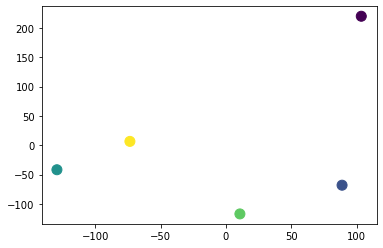

In [21]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(cmeans)
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1],c=[0,1,2,3,4],s=100)

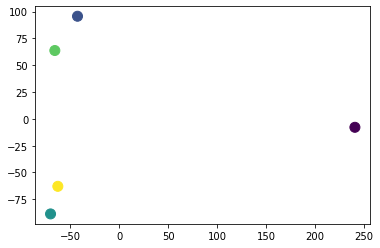

In [22]:
# PCA on cluster means
z_means = PCA(2).fit_transform(cmeans)
plt.scatter(z_means[:,0],z_means[:,1],c=[0,1,2,3,4],s=100)

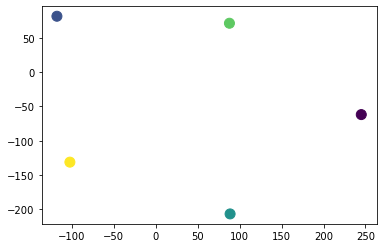

In [26]:
# Emergence of at least 5 clusters. 
z_means_tsne = TSNE(n_components=2,perplexity=40).fit_transform(cmeans)
plt.scatter(z_means_tsne[:,0],z_means_tsne[:,1],c=[0,1,2,3,4],s=100)

12. PCA/T-SNE on Raw Data

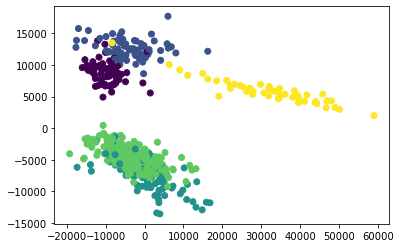

In [32]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1],c=y)

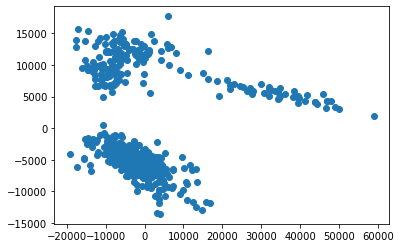

In [33]:
pca = PCA(50).fit(X)
z = pca.transform(X)
plt.scatter(z[:,0],z[:,1])

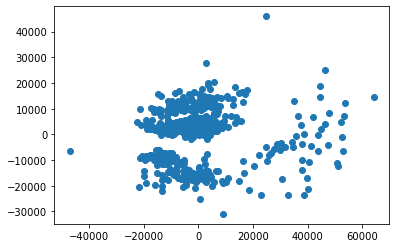

In [31]:
mds = MDS(n_components=2,verbose=1,eps=1e-5)
mds.fit(z[:,0:50])
plt.scatter(mds.embedding_[:,0],mds.embedding_[:,1])

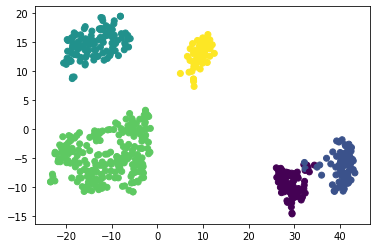

In [28]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1],c=y)

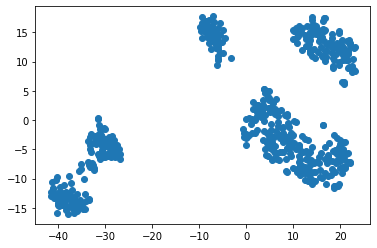

In [34]:
z_tsne = TSNE(n_components=2,perplexity=40).fit_transform(z[:,0:50])
plt.scatter(z_tsne[:,0],z_tsne[:,1])